<a href="https://colab.research.google.com/github/airctic/mantisshrimp/blob/master/notebooks/getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Mantisshrimp
![](https://github.com/ai-fast-track/mantisshrimp/blob/getting-start/images/mantisshrimp-logo.png?raw=1)

## Why Mantishrimp?

- It is an Agnostic Object-Detection Library

- Connects to different libraries/framework such as fastai, Pytorch Lightning, and Pytorch

- Features a Unified Data API such: common Parsers (COCO, VOC, etc.)

- Integrates community maintaned parsers for custom datasets shared on parsers hub

- Provides flexible model implementations using different backbones

- Helps both researchers and DL engineers in reproducing, replicating published models

- Facilitates applying both existing and new models to standard datasets as well as to Scustom datasets

## 1- Introduction

This tutorial walk you throug the different steps of training the PETS dataset. the Mantisshrimp Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) library.

## 2- Using Google Colab
First, enable the GPU runtime:  
`Runtime` -> `Change runtime type` -> `Hardware accelerator dropdown` -> `GPU`  

## 3- Packages Installations

In [ ]:
# Install Mantisshrimp package
!pip install git+git://github.com/airctic/mantisshrimp.git#egg=mantisshrimp[all] --upgrade

## 4- Imports

In [1]:
from mantisshrimp.imports import *
from mantisshrimp import *
from mantisshrimp.models.rcnn import faster_rcnn
import albumentations as A

## 5- Datasets : PETS example

Mantisshrimp provides very handy methods such as loading a dataset, parsing annotations, and more. In the example below, loading the PETS dataset is one line code. So is the pasrser.

In [2]:
path = datasets.pets.load()
path

Path('/root/.mantisshrimp/data/pets')

### 5.1- Parser
The `Parser` is one of the most important concepts of mantisshrimp, it's what allow us to work with **any** annotation format.

The basic idea of a parser is to convert any custom format to something the library can understand. We provide a wide variety of parsers via the `datasets` modules (each dataset will come with it's own parser), but you might still need to create a custom parser for your custom dataset. Fear not! Creating parsers is very easy, after you're finished with this tutorial, check this [documentation section](https://lgvaz.github.io/mantisshrimp/tutorials/mantisshrimp_data/intro_parser.html) to understand how to do so.

Mantisshrimp already provide a `parser` for the Pets Dataset

In [3]:
class_map = datasets.pets.class_map()
class_map

<ClassMap: {'background': 0, 'Abyssinian': 1, 'Bengal': 2, 'Birman': 3, 'Bombay': 4, 'British_Shorthair': 5, 'Egyptian_Mau': 6, 'Maine_Coon': 7, 'Persian': 8, 'Ragdoll': 9, 'Russian_Blue': 10, 'Siamese': 11, 'Sphynx': 12, 'american_bulldog': 13, 'american_pit_bull_terrier': 14, 'basset_hound': 15, 'beagle': 16, 'boxer': 17, 'chihuahua': 18, 'english_cocker_spaniel': 19, 'english_setter': 20, 'german_shorthaired': 21, 'great_pyrenees': 22, 'havanese': 23, 'japanese_chin': 24, 'keeshond': 25, 'leonberger': 26, 'miniature_pinscher': 27, 'newfoundland': 28, 'pomeranian': 29, 'pug': 30, 'saint_bernard': 31, 'samoyed': 32, 'scottish_terrier': 33, 'shiba_inu': 34, 'staffordshire_bull_terrier': 35, 'wheaten_terrier': 36, 'yorkshire_terrier': 37}>

In [4]:
parser = datasets.pets.parser(path, class_map)

### 5.2- Split the dataset
Next step is to define the `train/valid` splits for the data, let's use random splits for this one:


In [5]:
data_splitter = RandomSplitter([.8, .2])

### 5.3- Parsing data
Calling the `parse()` by passing the data splitter returns 2 records lists: one for the training and another for the validation datasets. 


In [6]:
train_records, valid_records = parser.parse(data_splitter)

!!! info "What's a record?"  
    A record is a dictionary that contains all parsed fields defined by the parser used.
    No matter what format the annotations used, a record has a common structure that can be connected to different DL frameworks (fastai, Pytorch-Lightning, etc.)

### 5.3- Visualization

Showing one single record (image + box + label)

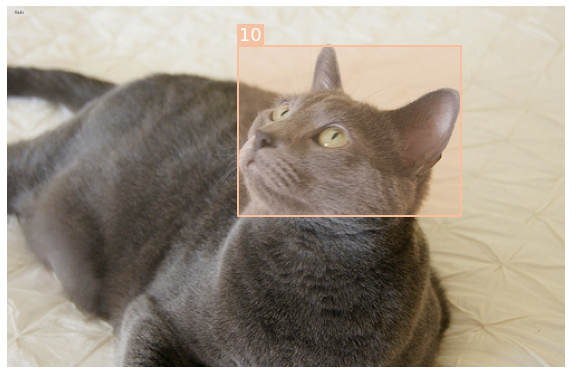

In [8]:
show_record(train_records[1])

Showing label instead of the class ID

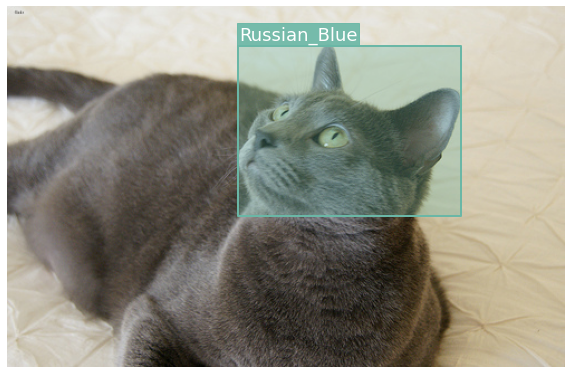

In [10]:
show_record(train_records[1], class_map=class_map)

Showing a batch of images with their corresponding boxes and labels

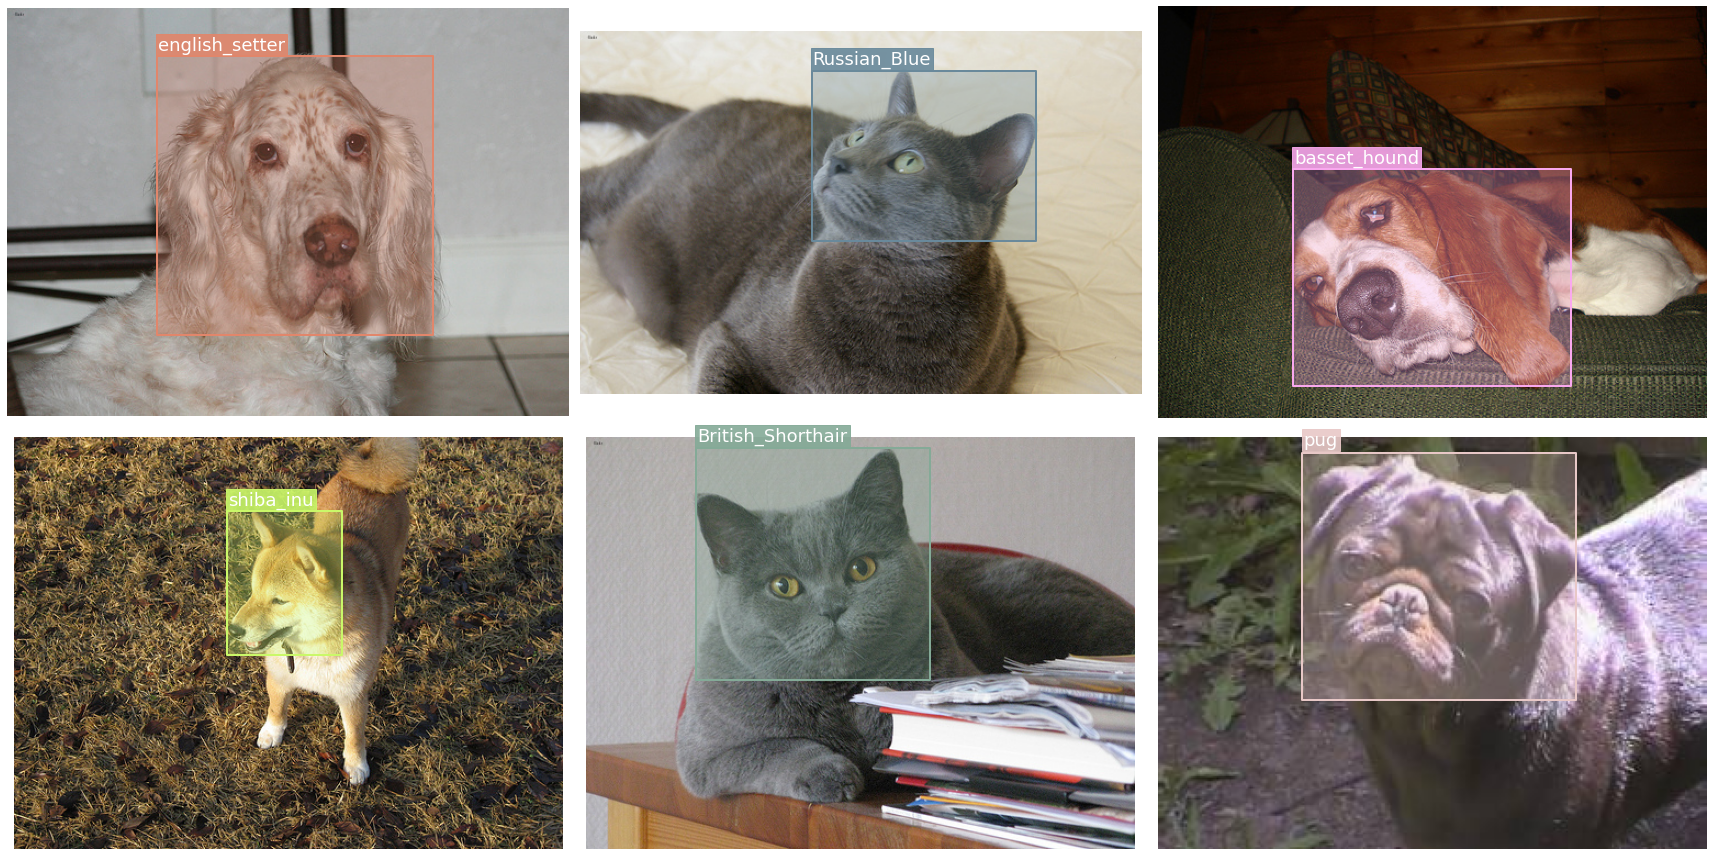

In [11]:
records = train_records[:6]
show_records(records, ncols=3, class_map=class_map)

## 6- Transforms

Transforms is an essential stage of any training pipeline, you can find a multitude of different transforms libraries online: [albumentations](https://github.com/albumentations-team/albumentations), [solt](https://github.com/MIPT-Oulu/solt), [torchvision](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image), only to cite a few.

With mantisshrimp you can use any transforms library, you just need to inherit and override all abstract methods of the `Transform` class.

To ease the user experience, we support for the widely used [albumentations](https://github.com/albumentations-team/albumentations) library, out-of-the-box. We plan to add more, in the future.

### 6.1- Train and Validation Dataset Transforms

In [13]:
presize = 512
size = 384

In [23]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

## 7- Dataset

Not to be confused with our previous `datasets` module, `Dataset` is a class that combines the records and transforms.

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally the transforms.


In [24]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

<div class="alert alert-info">

What a `Dataset` class  does?

  * Prepares the record: For example, in the record we just have a filename that points to the image, it's at this stage that we open the image.  
  * Apply the pipeline of transforms to record processed in the previous step

</div>

!!! info "Lazy transforms"  
    Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.  
    This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
    the dataset you will get a slightly different version of it.

!!! danger "Important"  
    Because we normalized our images with `imagenet_stats`, when displaying transformed images,  we need to denormalize them.  
    The `show_sample` function receives an optional argument called `denormalize_fn` that we can be passed: In our case, we pass `denormalize_imagenet`.


### 7.1- Displaying the same image with different transforms

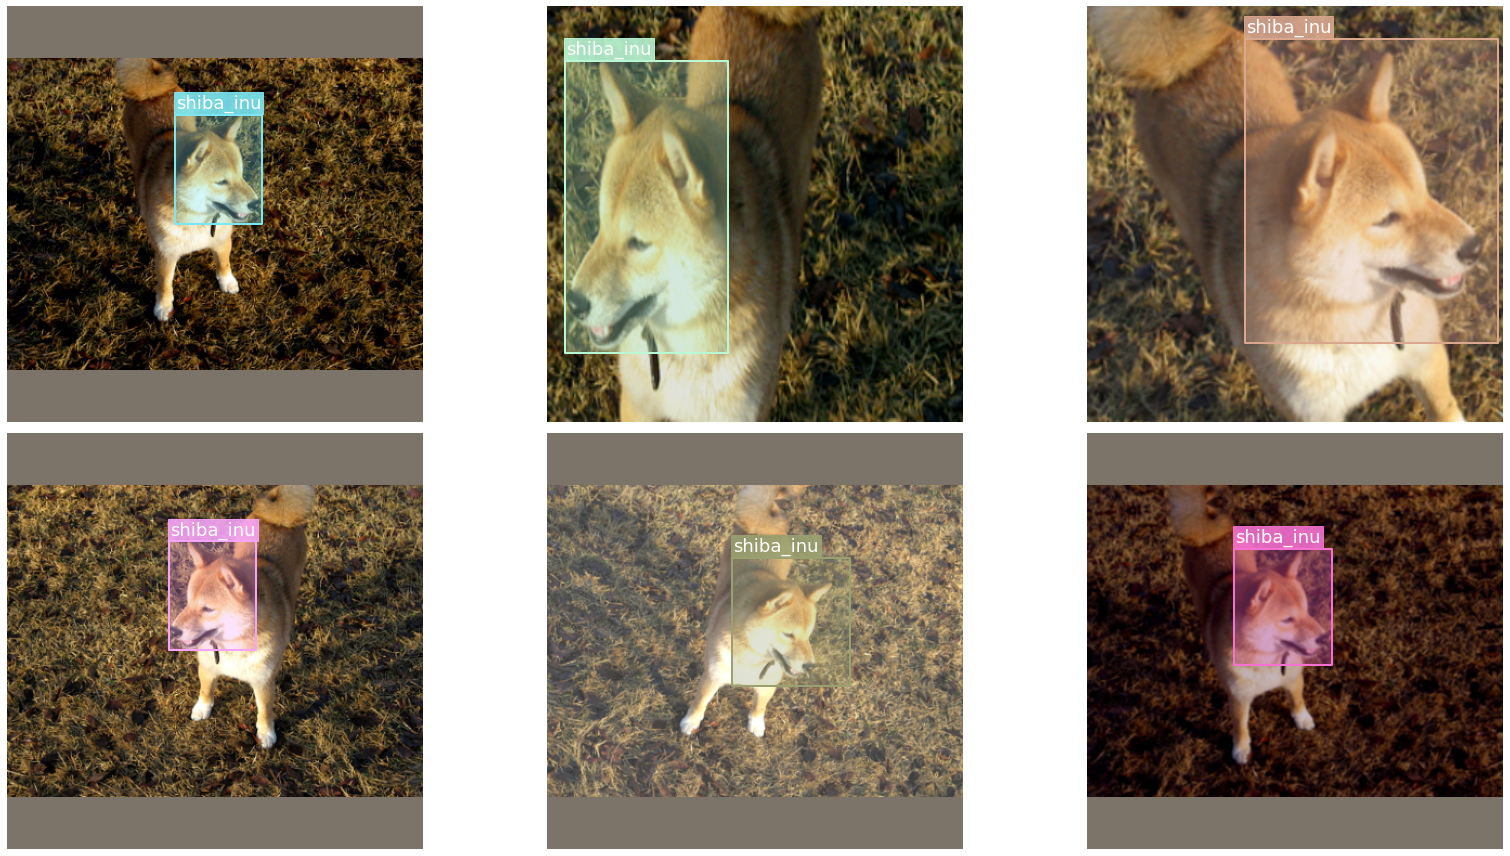

In [17]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

In this tutorial, we need to only predict bounding boxes, therefore we will use `FasterRCNN`. The only required argument we need to pass to the model is the number of classes of our dataset (which is simply the length of `datasets.pets.CATEGORIES`) + 1 for the background.

## 8- Model

In [25]:
model = faster_rcnn.model(num_classes=len(class_map))

## 9- DataLoader

Each model has its own dataloader (a pytorch `DataLoader`) that ccould be customized: the dataloaders for the RCNN models have a custom collate function.

In [26]:
train_dl = faster_rcnn.train_dataloader(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dataloader(valid_ds, batch_size=16, num_workers=4, shuffle=False)

## 10- Training

Mantisshrimp is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to others DL frameworks using your own custom code.

## 10.0 - Metrics

Metrics are essential for tracking the model progress as it's training.  
Here we are going to be using the famous `COCOMetric`:

In [27]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

### 10.1- Training using fastai
#### 10.1.1- Creating a Learner object
Creating a fastai compatible `Learner` using the fastai familiar interface 

In [45]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

#### 10.1.2- Training the RCNN model using fastai `fine_tune()` method

In [47]:
learn.fine_tune(10, lr=1e-4)

### 10.2- Training using Pytorch-Lightning

In [ ]:
# import lightning engine provided by the mantisshrimp modules
import pytorch_lightning as pl

#### 10.2.1- Creating a Pytorch-Lightning (PL) model class
It inherits from `RCNNLightningAdapter` and implements the method PL `configure_optimizers`.  

In [ ]:
class LightModel(faster_rcnn.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)

<div class="alert alert-info">
    
**Note:**
    
If you are used with lightning, you may be wondering what happened with `training_step`, `validation_step` and methods that we ussually have to override while using PL. Under the hood `RCNNLightningAdapter` implements those methods with the additional bennefit of supporting `Metric`s.  

If you need more custom functionality, feel free to re-implement those methods.  
    
</div>

In [ ]:
# Creating a PL model object
light_model = LightModel(model, metrics=metrics)

#### 10.2.2- Training the RCNN model using PL `Trainer.fit()` method

In [ ]:
trainer = pl.Trainer(max_epochs=10, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## 11- Inference

### 11.1- Load a model

Training the model with `fastai` using `fine_tune` twice and I got led the the following results:  
* train_loss: 0.070955
* valid_loss: 0.093732
* mAP: 0.6791

#### 11.2- Using our Trained Weights
If you don't want to train the model, you can use our rained weights that we publicly made vailable: You can download them with `torch.hub`:

In [61]:
weights_url = "https://mantisshrimp-models.s3.us-east-2.amazonaws.com/pets_faster_resnetfpn50.zip"
state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device("cpu"))

Downloading: "https://mantisshrimp-models.s3.us-east-2.amazonaws.com/pets_faster_resnetfpn50.zip" to /root/.cache/torch/hub/checkpoints/pets_faster_resnetfpn50.zip


!!! info "Note"  
    Typically inference is done on the cpu, this is why we specify the paramater `map_location` to `cpu` when loading the state dict.


Let's recreate the model and load the downloaded weights:

In [62]:
model = faster_rcnn.model(num_classes=len(class_map))
model.load_state_dict(state_dict)

<All keys matched successfully>

The first step for prediction is to have some images, let's grab some random ones from the validation dataset:

### 11.3- Predict all images at once

If you don't have too many images, you can get predictions with a single forward pass.  

In case your images don't fit in memory simultaneously, you should predict in batches, feel free to jump to the next section for how to do that.

For demonstration purposes, let's take download a single image from the internet and see how our model performs on it.

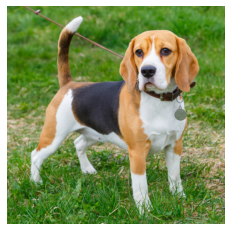

In [63]:
IMAGE_URL = "https://petcaramelo.com/wp-content/uploads/2018/06/beagle-cachorro.jpg"
IMG_PATH = "tmp.jpg"

download_url(IMAGE_URL, IMG_PATH)
img = open_img(IMG_PATH)
show_img(img)

!!! info "Try other images!"  
    Change `IMAGE_URL` to point to another image you found on the internet.  
    Just be sure to take one of the breeds from `class_map`, or else the model might get confused.

Whenever you have images in memory (numpy arrays) you can use `Dataset.from_images`.  

We're going to use the same transforms we used on the validation dataset.

In [64]:
infer_ds = Dataset.from_images([img], valid_tfms)

For any model, the prediction steps are always the same, first call `build_infer_batch` and then `predict`.

For `faster_rcnn` we have `detection_threshold`, which specifies how confident the model should be to output a bounding box.

In [65]:
batch, samples = faster_rcnn.build_infer_batch(infer_ds)
preds = faster_rcnn.predict(model=model, batch=batch)

For displaying the predictions, we first need to grab our image from `samples`. We do this instead of using the original images because transforms may have been applied to the image (in fact, in this case, a resize was used).

In [66]:
imgs = [sample["img"] for sample in samples]

Now we just need to call `show_preds`, to show the image with its corresponding predictions (boxes + labels).

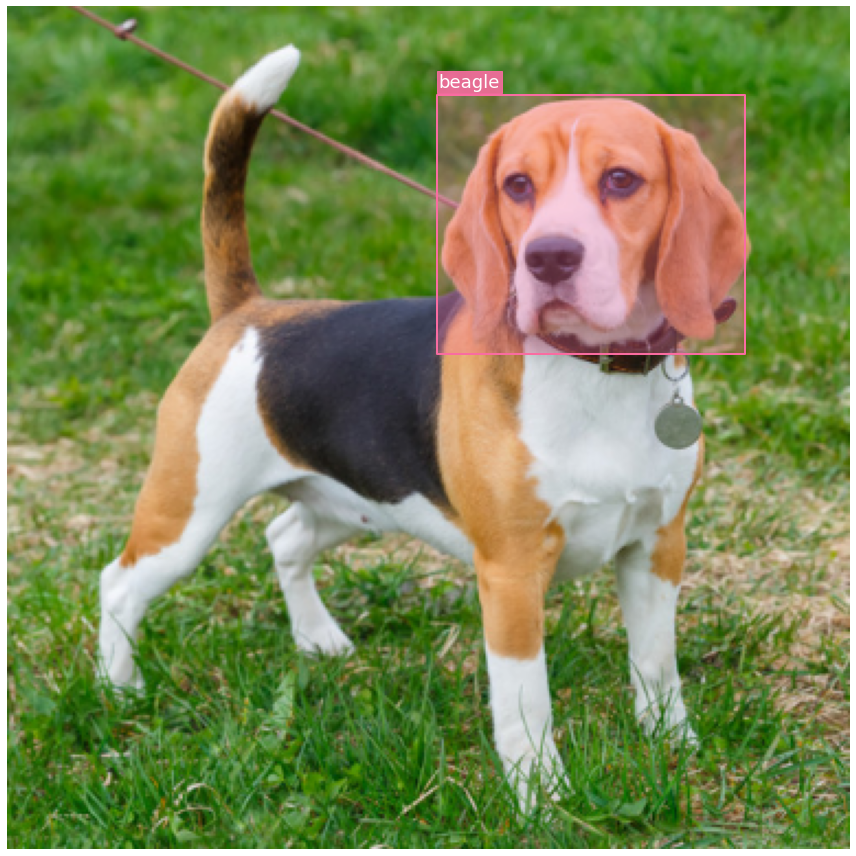

In [67]:
show_preds(
    imgs=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)

### 11.4- Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient: We use `infer_dataloader` 

Had we have a test dataset, we would have maken our predicition using the batch technique mentionned here above. As an illustrative example, we will predict all images belonging to the validation dataset using the following approach: 

In [70]:
# Let's use the gpu on this one
model.cuda()

infer_dl = faster_rcnn.infer_dataloader(valid_ds, batch_size=16)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

Same as before, we grab our images from `samples`.

In [71]:
imgs = [sample["img"] for sample in samples]

Let's show the first 6 predictions:

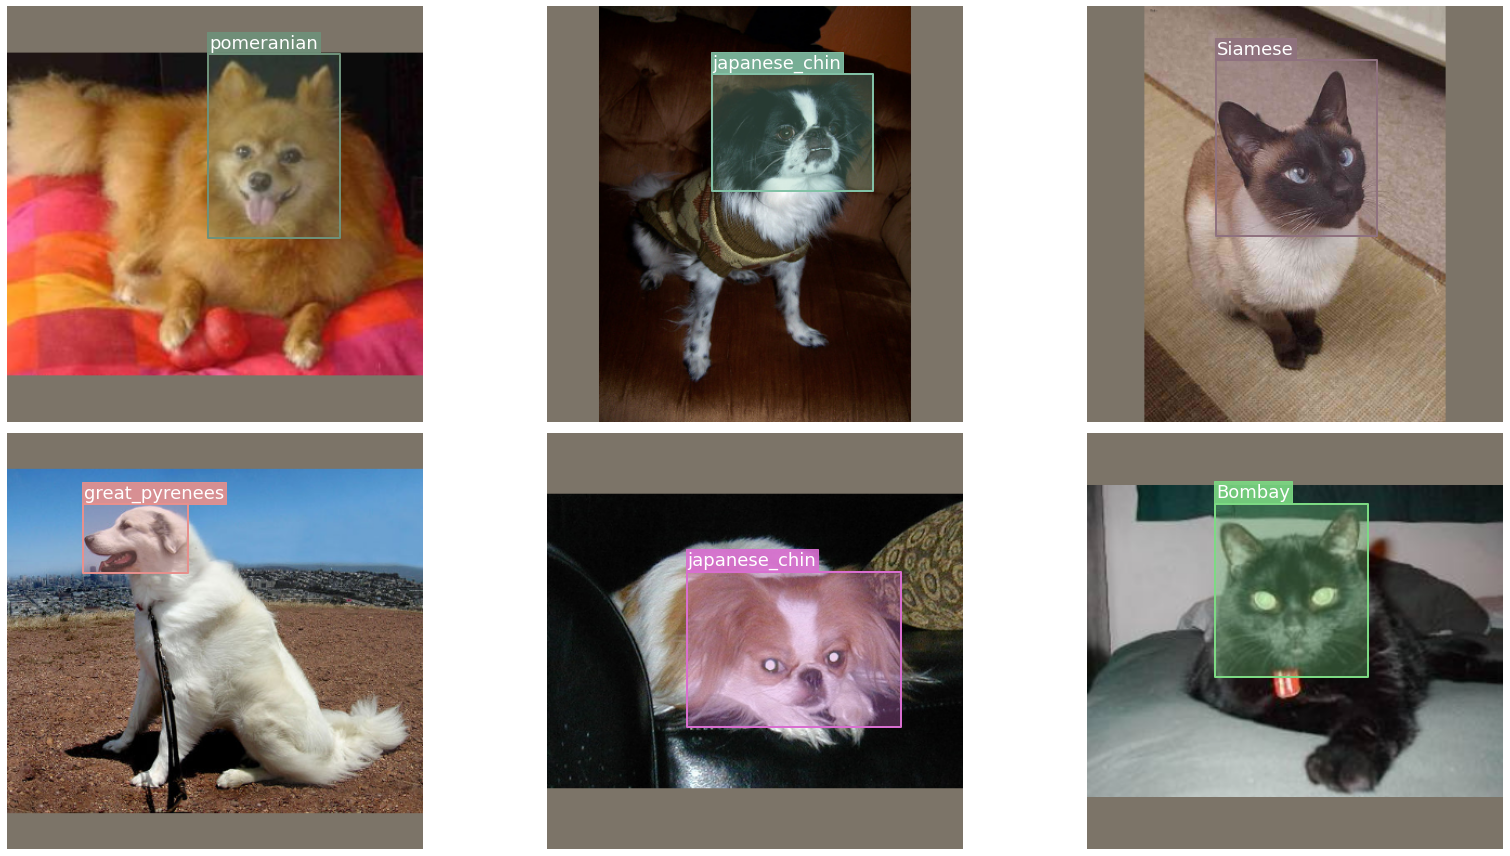

In [72]:
show_preds(
    imgs=imgs[:6],
    preds=preds[:6],
    ncols=3,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)

## Happy Learning!

If you need any assistance, feel free to reach out at us [here](https://github.com/lgvaz/mantisshrimp/tree/master/mantisshrimp)